In [1]:
%matplotlib inline
from setting.matplotlib_ import *
from setting.tools import *

In [2]:
print("This notebook was built with:")
print("python version: %s " % sys.version)
print("PCSE version: %s" %  pcse.__version__)

This notebook was built with:
python version: 3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0] 
PCSE version: 5.5.0


거의 모든 과정이 동일합니다. <br>
목표만 하나 추가해주면 됩니다.

## Loading environment data

In [3]:
target_env = pd.read_csv('./data/pap_env_RDA_open.csv', skiprows=1, header=None)
target_env.loc[:, 0] = pd.DatetimeIndex(target_env.loc[:, 0])
template = pd.read_excel('./data/data_template.xls', header=None)

In [4]:
target_env = pd.concat([template.loc[:11], target_env], axis=0)

In [5]:
target_env.to_excel('./data/pap_env_processed.xls', index=False, header=False)

/tmp/ipykernel_256952/2866564418.py:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  target_env.to_excel('./data/pap_env_processed.xls', index=False, header=False)


## Loading growth data

In [6]:
target_output = pd.read_csv(f'./data/pap_grw_RDA_open.csv', index_col='date')
target_output['LAI'] = (target_output['lefCunt']*target_output['lefLt']*target_output['lefBt'])/1000
target_output.index = pd.DatetimeIndex(target_output.index)

In [7]:
target_output.loc[target_output['LAI'] == 0, 'LAI'] = np.nan
target_output.loc[:, 'LAI'] = target_output.loc[:, 'LAI'].ffill()
target_output = target_output.loc[~target_output.loc[:, 'LAI'].isna()]

In [8]:
target_output = target_output.loc[:, ['LAI', 'cum_harvest']]
target_output.columns = ['LAI', 'TWSO']

<AxesSubplot:xlabel='date'>

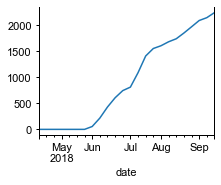

In [9]:
target_output.TWSO.plot()

수확량에 대한 지표로 TWSO를 선택해서 목표로 삼습니다.

In [10]:
CROP_NAME = 'soybean'
VARIETY_NAME = 'Soybean_906'
START_DATE = str(pd.Timestamp('2018-03-23').date()) # starting date was deleted because of dropna
END_DATE = str(target_output.index[-1].date())
CULT_PERIOD = (pd.Timestamp(END_DATE)- pd.Timestamp(START_DATE)).days
print(f'from {START_DATE} to {END_DATE}: {CULT_PERIOD} days')

from 2018-03-23 to 2018-09-21: 182 days


## Input data for WOFOST

In [11]:
cropd = YAMLCropDataProvider()
soild = DummySoilDataProvider()
sited = WOFOST72SiteDataProvider(WAV=50, CO2=360.)
params = ParameterProvider(cropdata=cropd, sitedata=sited, soildata=soild)

In [12]:
# Agromanagement for the custom data
agro_yaml = f"""
- {START_DATE}:
    CropCalendar:
        crop_name: {CROP_NAME}
        variety_name: {VARIETY_NAME}
        crop_start_date: {START_DATE}
        crop_start_type: emergence
        crop_end_date: {END_DATE}
        max_duration: {CULT_PERIOD}
    TimedEvents: null
    StateEvents: null
"""
agro = yaml.load(agro_yaml, Loader=yaml.FullLoader)

In [13]:
wdp = ExcelWeatherDataProvider('./data/pap_env_processed.xls')

## WOFOST Initialization

In [14]:
wofost = Wofost72_PP(params, wdp, agro)
wofost.run_till_terminate()

## Parameter selection

In [15]:
target_params = ['TDWI', 'TBASE', 'TSUM1', 'TSUM2', 'RGRLAI', 'SPAN', 'PERDL',
                 'SLATB', 'FRTB', 'AMAXTB']
target_obj = ['TWSO', 'LAI']
params_range = [[0, 2000], [0, 30], [500, 1000], [2000, 4000], [0, 0.01], [0, 500], [0, 1]]
params_range_tb = [[0.001, 0.005, 3], [0, 1, 3], [0, 50, 3]] # [min, max, repeat]

In [16]:
origin_value = {}
for k in target_params:
    v = params._cropdata[k]
    origin_value[k] = v

## HyperOpt preparation

In [17]:
space = {}
for p, r, in zip([_ for _ in target_params if not _.endswith('TB')], params_range):
    space[p] = hp.uniform(p, r[0], r[1])
for p, r, in zip([_ for _ in target_params if _.endswith('TB')], params_range_tb):
    for i in range(r[2]):
        space[f'{p}_{i}'] = hp.uniform(f'{p}_{i}', r[0], r[1])

## Optimization process

In [18]:
objfunc_calculator = ObjectiveFunctionCalculator(target_params, target_obj, params, wdp, agro, target_output)

In [19]:
best = fmin(fn=objfunc_calculator, space=space, algo=tpe.suggest, max_evals=50)

100%|█████████| 50/50 [00:12<00:00,  4.08trial/s, best loss: 0.8263846812954897]


## Result

In [20]:
print('<Calibration result>')
for k in target_params:
    if not k.endswith('TB'):
        print(f'{k}: {origin_value[k]} -> {best[k]:.2f}')
    else:
        TARGET = [x for x in best.keys() if x.startswith(k)]
        temp_list = []
        for v1, v2 in zip(np.linspace(0.0, 2.0, len(TARGET)), [best[_] for _ in TARGET]):
            temp_list.append(v1)
            temp_list.append(v2)
        print(f'{k}: {origin_value[k]} -> {[np.round(_, 4) for _ in temp_list]}')

<Calibration result>
TDWI: 120.0 -> 462.78
TBASE: 7.0 -> 16.85
TSUM1: 500 -> 721.86
TSUM2: 1300 -> 3350.27
RGRLAI: 0.007 -> 0.01
SPAN: 23.0 -> 180.11
PERDL: 0.03 -> 0.06
SLATB: [0.0, 0.0014, 0.45, 0.0025, 0.9, 0.0025, 2.0, 0.0007] -> [0.0, 0.002, 1.0, 0.0033, 2.0, 0.0021]
FRTB: [0.0, 0.65, 0.75, 0.45, 1.0, 0.2, 1.5, 0.0, 2.0, 0.0] -> [0.0, 0.4351, 1.0, 0.0716, 2.0, 0.4807]
AMAXTB: [0.0, 29.0, 1.7, 29.0, 2.0, 0.0] -> [0.0, 21.7842, 1.0, 17.5925, 2.0, 27.9725]


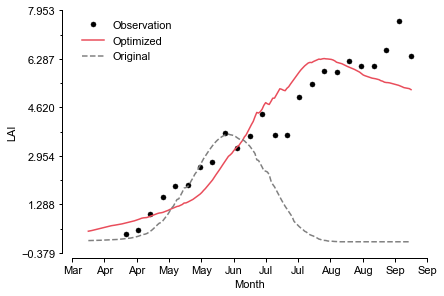

In [21]:
fig = plt.figure(figsize=((8/2.54*2), (6/2.54*1.8)))
ax = plt.subplot()
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 5))

ax.plot(target_output.index, target_output.LAI, 'o', ms=5, mew=0.5, mec='k', c='k', label="Observation")
_ = objfunc_calculator(best)
ax.plot(objfunc_calculator.df_sim.index, objfunc_calculator.df_sim.LAI, c=cmap[0], label="Optimized")
_ = objfunc_calculator(origin_value)
ax.plot(objfunc_calculator.df_sim.index, objfunc_calculator.df_sim.LAI, "--", c='gray', label="Original")

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(LinearLocator(12))
ax.yaxis.set_major_locator(LinearLocator(6))
ax.yaxis.set_minor_locator(LinearLocator(11))
ax.set_xlabel('Month')
ax.set_ylabel('LAI')

ax.legend(frameon=False, loc=0)
fig.tight_layout()
plt.show()

In [22]:
compare_df = pd.read_csv(f'./data/pap_grw_RDA_open.csv', index_col='date')
compare_df.index = pd.DatetimeIndex(compare_df.index)

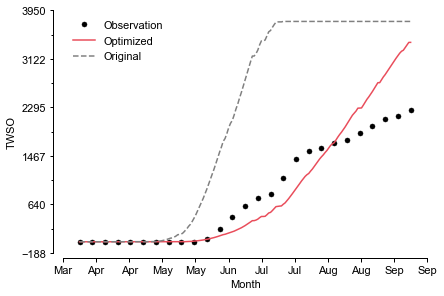

In [23]:
# rerun with the best parameters found
fig = plt.figure(figsize=((8/2.54*2), (6/2.54*1.8)))
ax = plt.subplot()
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 5))

ax.plot(compare_df.index, compare_df.cum_harvest, 'o', ms=5, mew=0.5, mec='k', c='k', label="Observation")
_ = objfunc_calculator(best)
ax.plot(objfunc_calculator.df_sim.index, objfunc_calculator.df_sim.TWSO, c=cmap[0], label="Optimized")
_ = objfunc_calculator(origin_value)
ax.plot(objfunc_calculator.df_sim.index, objfunc_calculator.df_sim.TWSO, "--", c='gray', label="Original")

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(LinearLocator(12))
ax.yaxis.set_major_locator(LinearLocator(6))
ax.yaxis.set_minor_locator(LinearLocator(11))
# ax.set_ybound(0, 5)
ax.set_xlabel('Month')
ax.set_ylabel('TWSO')

ax.legend(frameon=False, loc=0)
fig.tight_layout()
plt.show()

간단하게 한 항목 추가하는 것으로 TWSO에 대해서도 최적화할 수 있습니다.